In [2]:
import pandas as pd
import numpy as np


In [3]:
df = pd.read_csv("Bitcoin_BTCUSDT.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp")


Matplotlib is building the font cache; this may take a moment.


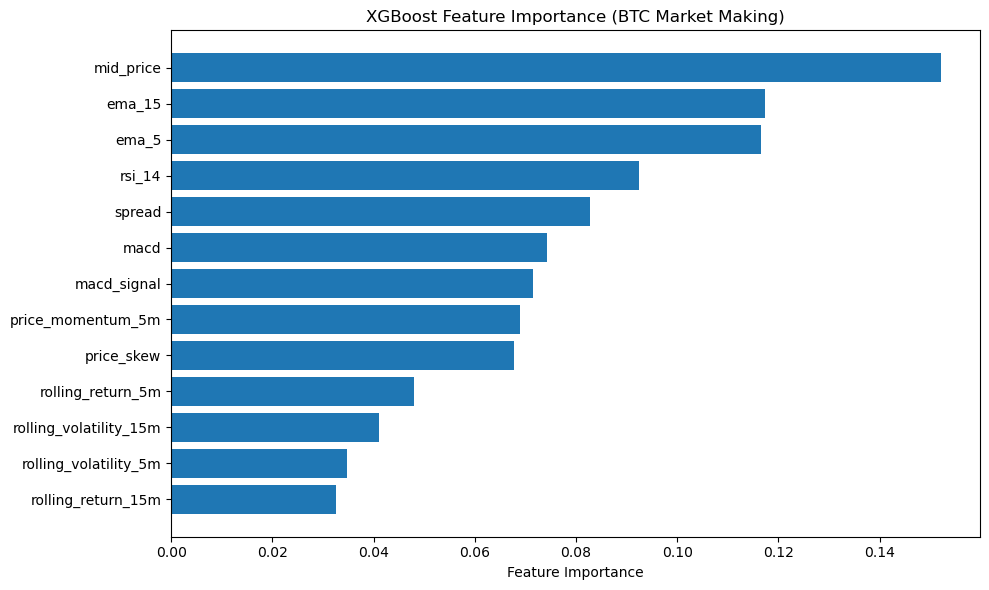

In [4]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Load your actual BTC minute data
'''df = pd.read_csv("your_btc_data.csv")  # replace with actual filename
df['timestamp'] = pd.to_datetime(df['timestamp'])  # if needed
df.sort_values('timestamp', inplace=True)'''

# --- Feature Engineering ---
df['mid_price'] = (df['high'] + df['low']) / 2
df['spread'] = df['high'] - df['low']

# Rolling volatility
df['rolling_volatility_5m'] = df['close'].pct_change().rolling(5).std()
df['rolling_volatility_15m'] = df['close'].pct_change().rolling(15).std()

# Rolling returns
df['rolling_return_5m'] = df['close'].pct_change(5)
df['rolling_return_15m'] = df['close'].pct_change(15)

# EMAs
df['ema_5'] = df['close'].ewm(span=5).mean()
df['ema_15'] = df['close'].ewm(span=15).mean()

# Price momentum and skew
df['price_momentum_5m'] = df['close'] - df['close'].shift(5)
df['price_skew'] = (df['high'] - df['close']) - (df['close'] - df['low'])

# RSI (14-period)
delta = df['close'].diff()
gain = delta.where(delta > 0, 0.0)
loss = -delta.where(delta < 0, 0.0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['rsi_14'] = 100 - (100 / (1 + rs))

# MACD and Signal
ema12 = df['close'].ewm(span=12).mean()
ema26 = df['close'].ewm(span=26).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9).mean()

# --- Target: 5-minute forward return ---
df['target'] = df['close'].shift(-5) / df['close'] - 1

# --- Clean and prepare ---
df.dropna(inplace=True)

features = [
    'mid_price', 'spread', 'rolling_volatility_5m', 'rolling_volatility_15m',
    'rolling_return_5m', 'rolling_return_15m', 'ema_5', 'ema_15',
    'price_momentum_5m', 'price_skew', 'rsi_14', 'macd', 'macd_signal'
]

X = df[features]
y = df['target']

# --- Train XGBoost Regressor ---
model = XGBRegressor(n_estimators=100, max_depth=4, random_state=42)
model.fit(X, y)

# --- Plot feature importances ---
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance (BTC Market Making)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [8]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import joblib

# Define your top 5 features and target
features = ['mid_price', 'ema_15', 'ema_5', 'rsi_14', 'spread']

# Drop rows with NaNs (common in rolling calculations)
df = df.dropna(subset=features + ['target'])

# Prepare data
X = df[features]
y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# XGBoost regressor
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.6f}")

# Save the model
joblib.dump(model, "xgboost_top5_btc_model.pkl")


Test RMSE: 0.002148


['xgboost_top5_btc_model.pkl']